# CycleGAN for SVHN --> MNIST transfer
Adaptation of this [paper](https://arxiv.org/pdf/1703.10593.pdf) for transforming the SVHN domain to the MNIST one
Other papers used:

[1] **Instance Noise** : https://arxiv.org/pdf/1610.04490.pdf

[2] **Discriminator Regularizer** : https://arxiv.org/pdf/1705.09367.pdf

[3] **Gradient penalty** (DRAGAN) : https://arxiv.org/pdf/1705.07215.pdf

[4] **Instance normalization** : https://arxiv.org/abs/1607.08022

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import color, transform

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.gan.python.losses.python import losses_impl

from torchvision import datasets
from torchvision import transforms

from IPython.display import clear_output

/home/arthur/miniconda3/envs/tl-gpu/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

In [3]:
def normalize(x, max_value):
    """ Normalize the input between -1 and 1 """
    return (x / float(max_value)) * 2 - 1

### SVHN

In [4]:
svhn = datasets.SVHN(root="/home/arthur/datasets/svhn", download=False)

In [5]:
X_svhn = svhn.data
X_svhn = np.transpose(X_svhn, (0,2,3,1))
X_svhn = np.array([color.rgb2gray(im) for im in X_svhn])
X_svhn = normalize(X_svhn, 256)
X_svhn = X_svhn.reshape(len(X_svhn), 32, 32, 1)
Y_svhn = svhn.labels.flatten()%10
X_svhn.shape

(73257, 32, 32, 1)

### MNIST

In [6]:
mnist = input_data.read_data_sets('/home/arthur/datasets/mnist', one_hot=False)

Extracting /home/arthur/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [7]:
X_mnist = mnist.train.images
X_mnist = X_mnist.reshape(len(X_mnist), 28, 28)
X_mnist = np.array([transform.resize(im, [32,32]) for im in X_mnist])
X_mnist = normalize(X_mnist, 1)
X_mnist = X_mnist.reshape(len(X_mnist), 32, 32, 1)
Y_mnist = mnist.train.labels
X_mnist.shape

/home/arthur/miniconda3/envs/tl-gpu/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(55000, 32, 32, 1)

In [8]:
X_source = X_svhn
X_target = X_mnist

## Create the model

### Useful functions

In [9]:
def leaky_relu(x):
    alpha = 0.05
    return tf.maximum(x, alpha * x)

In [10]:
def instance_normalization(x, name):
    with tf.variable_scope("instance_norm"):
        with tf.variable_scope(name):
            epsilon = 1e-5
            mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
            scale = tf.get_variable('scale',[x.get_shape()[-1]], 
                initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.02))
            offset = tf.get_variable('offset',[x.get_shape()[-1]],initializer=tf.constant_initializer(0.0))
            out = scale*tf.div(x-mean, tf.sqrt(var+epsilon)) + offset

            return out

In [11]:
def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_layer + noise

### Placeholders

In [12]:
ipt_source = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='ipt_source')
ipt_target = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='ipt_target')
latent_space = tf.placeholder(tf.float32, shape=[None, 4, 4, 4], name='latent_space')
gamma_plh = tf.placeholder(tf.float32, shape=(), name='gamma')

### Discriminator Network

In [13]:
def discriminator(x): 
    initializer = tf.contrib.layers.xavier_initializer()

    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        # Layer 1: 32x32xn --> 16x16x32 (n=1 or 3)
#         x_noisy = gaussian_noise_layer(x, 0)
        conv1 = tf.layers.conv2d(x, 64, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")
        
        # Layer 2: 16x16x32 --> 8x8x16        
        conv2 = tf.layers.conv2d(conv1, 32, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")
        
        # Layer 3: 8x8x16 --> 4x4x16     
        conv3 = tf.layers.conv2d(conv2, 16, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv3 = instance_normalization(conv3, "conv3")

        # Layer 3: 4x4x32 --> 1
        fc1 = tf.contrib.layers.flatten(conv3)
        fc1_logits = tf.layers.dense(inputs=fc1, units=1, activation=None, kernel_initializer=initializer)
        fc1_sigmoid = tf.sigmoid(fc1_logits)
        
    return fc1_sigmoid, fc1_logits

### Generator Network

In [14]:
def generator(x, z):
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("generator", reuse=None):
        # Layer 1: 32x32x1 --> 16x16x64
        conv1 = tf.layers.conv2d(x, 64, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")

        # Layer 2: 16x16x64 --> 8x8x32
        conv2 = tf.layers.conv2d(conv1, 32, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")
        
        # Layer 3: 8x8x32 --> 4x4x16
        conv3 = tf.layers.conv2d(conv2, 16, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv3 = instance_normalization(conv3, "conv3")
        
        # Layer 3 bis (add latent space): 4x4x16 --> 4x4x20
        embed = tf.concat([conv3, z], 3)
        
        # Layer 4: 4x4x16 --> 8x8x32
        deconv1 = tf.layers.conv2d_transpose(embed, 32, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv1 = instance_normalization(deconv1, "deconv1")
        
        # Layer 5: 8x8x32 --> 16x16x64
        deconv2 = tf.layers.conv2d_transpose(deconv1, 64, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv2 = instance_normalization(deconv2, "deconv2")
        
        # Layer 6: 16x16x64 --> 32x32x1
        deconv3 = tf.layers.conv2d_transpose(deconv2, 1, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=tf.nn.tanh)

    return deconv3, embed

### Define the graph

In [15]:
def log(tensor):
    return tf.log(tf.maximum(tensor, 1e-9))

In [16]:
with tf.variable_scope("s2t") as scope:
    D_target, D_target_logits = discriminator(ipt_target)
    G_target, E_target = generator(ipt_source, latent_space)
    scope.reuse_variables()
    DG_target, DG_target_logits = discriminator(G_target)

In [17]:
with tf.variable_scope("t2s") as scope:
    D_source, D_source_logits = discriminator(ipt_source)
    G_source, E_source = generator(ipt_target, latent_space)
    scope.reuse_variables()
    DG_source, DG_source_logits = discriminator(G_source)

In [18]:
with tf.variable_scope("s2t", reuse=True) as scope:
    cyc_target, cyc_emb_target = generator(G_source, latent_space) # take the embedding

In [19]:
with tf.variable_scope("t2s", reuse=True) as scope:
    cyc_source, cyc_emb_source = generator(G_target, latent_space) # take the embedding

### Losses

In [20]:
batch_size = 64

#### Cycle Loss

In [21]:
lambda_cyc = 5

In [22]:
cyc_loss = tf.losses.mean_squared_error(ipt_source, cyc_source) + tf.losses.mean_squared_error(ipt_target, cyc_target)
tf.summary.scalar("cyc_loss", cyc_loss)

<tf.Tensor 'cyc_loss:0' shape=() dtype=string>

#### Gradient penalty

In [23]:
lambda_pen = 0

In [24]:
def gradient_penalty(X, scope):
    with tf.variable_scope(scope) as s:
        alpha = tf.random_uniform([1], minval=0., maxval=1.)
        X_p = X + tf.random_uniform([batch_size, 32, 32, 1])
        differences = X_p - X
        interpolates = X + (alpha*differences)
        gradients = tf.gradients(discriminator(interpolates)[1], [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
        grad_pen = tf.reduce_mean((slopes-1.)**2)
    
    return grad_pen

#### Discriminator regularizer

In [25]:
def discriminator_regularizer(D1_logits, D1_arg, D2_logits, D2_arg):
    D1 = tf.nn.sigmoid(D1_logits)
    D2 = tf.nn.sigmoid(D2_logits)
    grad_D1_logits = tf.gradients(D1_logits, D1_arg)[0]
    grad_D2_logits = tf.gradients(D2_logits, D2_arg)[0]
    grad_D1_logits_norm = tf.norm(tf.reshape(grad_D1_logits, [batch_size,-1]), axis=1, keep_dims=True)
    grad_D2_logits_norm = tf.norm(tf.reshape(grad_D2_logits, [batch_size,-1]), axis=1, keep_dims=True)

    reg_D1 = tf.multiply(tf.square(1.0-D1), tf.square(grad_D1_logits_norm))
    reg_D2 = tf.multiply(tf.square(D2), tf.square(grad_D2_logits_norm))
    disc_regularizer = tf.reduce_mean(reg_D1 + reg_D2)
    return disc_regularizer

#### GAN losses

In [26]:
def lsgan_disc_loss(D_real, D_gen):
    return 1/2 * tf.reduce_mean((D_real - 1)**2) + 1/2 * tf.reduce_mean(D_gen**2)

def lsgan_gen_loss(D_gen):
    return 1/2 * tf.reduce_mean((D_gen - 1)**2)

In [27]:
def wasserstein_disc_loss(D_real, D_gen):
    """ Warning : take logits as input"""
    return tf.reduce_mean(D_gen) - tf.reduce_mean(D_real)

def wasserstein_gen_loss(D_gen):
    """ Warning : take logits as input"""
    return -tf.reduce_mean(D_gen)

In [28]:
def original_disc_loss(D_real, D_gen):
    """ Warning : take logits as input"""
    return tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real))
        + tf.nn.sigmoid_cross_entropy_with_logits(logits=D_gen, labels=tf.zeros_like(D_gen)))

def original_gen_loss(D_gen):
    """ Warning : take logits as input"""
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_gen, labels=tf.ones_like(D_gen)))

In [29]:
D_s2t_loss = wasserstein_disc_loss(D_target_logits, DG_target_logits)
D_s2t_loss += lambda_pen * gradient_penalty(ipt_source, "s2t")
# D_s2t_loss += 0.5 * gamma_plh * discriminator_regularizer(D_target_logits, ipt_target, DG_target_logits, G_target)

G_s2t_loss = wasserstein_gen_loss(DG_target_logits)
G_s2t_loss += lambda_cyc*cyc_loss

tf.summary.scalar("D_s2t_loss", D_s2t_loss)
tf.summary.scalar("G_s2t_loss", G_s2t_loss)

<tf.Tensor 'G_s2t_loss:0' shape=() dtype=string>

In [30]:
D_t2s_loss = wasserstein_disc_loss(D_source_logits, DG_source_logits)
D_t2s_loss += lambda_pen * gradient_penalty(ipt_target, "t2s")
# D_t2s_loss += 0.5 * gamma_plh * discriminator_regularizer(D_source_logits, ipt_source, DG_source_logits, G_source)

G_t2s_loss = wasserstein_gen_loss(DG_source_logits)
G_t2s_loss += lambda_cyc*cyc_loss

tf.summary.scalar("D_t2s_loss", D_t2s_loss)
tf.summary.scalar("G_t2s_loss", D_t2s_loss)

<tf.Tensor 'G_t2s_loss:0' shape=() dtype=string>

#### Solvers

In [31]:
model_vars = tf.trainable_variables()

D_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/discriminator')
G_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/generator')
D_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/discriminator')
G_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/generator')

In [32]:
D_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(D_s2t_loss, var_list=D_s2t_vars)
G_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(G_s2t_loss, var_list=G_s2t_vars)
D_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(D_t2s_loss, var_list=D_t2s_vars)
G_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(G_t2s_loss, var_list=G_t2s_vars)

In [33]:
clip_D_s2t = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_s2t_vars]
clip_D_t2s = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_t2s_vars]

## Run the model

In [34]:
sess = tf.InteractiveSession()

In [47]:
sess.run(tf.global_variables_initializer())
D_s2t_loss_list = []
G_s2t_loss_list = []
D_t2s_loss_list = []
G_t2s_loss_list = []
cyc_loss_list = []
iter_list = []
i = 0

In [48]:
saver = tf.train.Saver()
# saver.restore(sess, "model/model.ckpt")

In [49]:
# D_s2t_loss_list = list(np.loadtxt("D_s2t_loss_list.txt"))
# G_s2t_loss_list = list(np.loadtxt("G_s2t_loss_list.txt"))
# D_t2s_loss_list = list(np.loadtxt("D_t2s_loss_list.txt"))
# G_t2s_loss_list = list(np.loadtxt("G_t2s_loss_list.txt"))
# iter_list = list(np.loadtxt("iter_list.txt"))
# i = len(iter_list)

In [140]:
###!!!!! TODO : pretrain MNIST --> SVHN as an autoencoder !!!!! ###

nb_iter = 5000
nb_iter_d = 2
nb_iter_g = 1
G_s2t_loss_curr = 0.001
D_s2t_loss_curr = 0.001
G_t2s_loss_curr = 0.001
D_t2s_loss_curr = 0.001
cyc_loss_curr = 0.001
verbose = True

i_init = i
for i in range(i, nb_iter+i):
    for k in range(nb_iter_g):
        sample_source = X_source[np.random.choice(len(X_source), batch_size)]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
#         noise = sess.run(tf.random_normal([batch_size, 4, 4, 4]))
        noise = np.random.random((batch_size, 4, 4, 4))
        
        # Optimizing s2t
        _, G_s2t_loss_curr = sess.run([G_s2t_solver, G_s2t_loss], feed_dict={ipt_source: sample_source, 
                                                                             ipt_target: sample_target, 
                                                                             latent_space: noise})
    
        ## Optimizing t2s
        _, G_t2s_loss_curr = sess.run([G_t2s_solver, G_t2s_loss], feed_dict={ipt_source: sample_source, 
                                                                             ipt_target: sample_target, 
                                                                             latent_space: noise})
        
    for k in range(nb_iter_d):
        sample_source = X_source[np.random.choice(len(X_source), batch_size)]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
#         noise = sess.run(tf.random_normal([batch_size, 4, 4, 4]))
        noise = np.random.random((batch_size, 4, 4, 4))
        gamma = 0
        
        # Optimizing s2t
        _, D_s2t_loss_curr,_ = sess.run([D_s2t_solver, D_s2t_loss, clip_D_s2t], feed_dict={ipt_source: sample_source, 
                                                                             ipt_target: sample_target, 
                                                                             latent_space: noise, 
                                                                             gamma_plh: gamma})
    
        ## Optimizing t2s
        _, D_t2s_loss_curr,_ = sess.run([D_t2s_solver, D_t2s_loss, clip_D_t2s], feed_dict={ipt_source: sample_source, 
                                                                             ipt_target: sample_target, 
                                                                             latent_space: noise, 
                                                                             gamma_plh: gamma})

    iter_list.append(i)
    cyc_loss_curr, = sess.run([cyc_loss], feed_dict={ipt_source: sample_source, 
                                                     ipt_target: sample_target, 
                                                     latent_space: noise})
    D_s2t_loss_list.append(D_s2t_loss_curr)
    G_s2t_loss_list.append(G_s2t_loss_curr)
    D_t2s_loss_list.append(D_t2s_loss_curr)
    G_t2s_loss_list.append(G_t2s_loss_curr)
    cyc_loss_list.append(cyc_loss_curr)
    
    if verbose:
        clear_output(wait=True)
        print('Iter: {} / {}'.format(i, i_init + nb_iter - 1))
        print('D loss s2t: {:.4}'.format(D_s2t_loss_curr))
        print('D loss t2s: {:.4}'.format(D_t2s_loss_curr))
        print('G loss s2t: {:.4}'.format(G_s2t_loss_curr))
        print('G loss t2s: {:.4}'.format(G_t2s_loss_curr))
        print('Cycle-loss: {:.4}'.format(cyc_loss_curr))
        print()
    
#     if i % (nb_iter//10) == 0:
# #         summary = sess.run([merged_summary], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
# #         summary_writer.add_summary(summary, i)

print("Saving model...")
saver.save(sess, "model/model.ckpt")
np.savetxt("D_s2t_loss_list.txt", D_s2t_loss_list)
np.savetxt("G_s2t_loss_list.txt", G_s2t_loss_list)
np.savetxt("D_t2s_loss_list.txt", D_t2s_loss_list)
np.savetxt("G_t2s_loss_list.txt", G_t2s_loss_list)
np.savetxt("iter_list.txt", iter_list)

        
# summary_writer.flush()

Iter: 24175 / 25238
D loss s2t: -4.575
D loss t2s: -5.087
G loss s2t: 2.544
G loss t2s: 2.673
Cycle-loss: 0.0228



KeyboardInterrupt: 

## Display the results

In [141]:
def unnormalize(x):
    return (x + 1)/2

In [154]:
noise = np.zeros((64,4,4,4))
X_source_trans = unnormalize(sess.run(G_target, feed_dict={ipt_source: X_source[:64], latent_space: noise}))
X_target_trans = unnormalize(sess.run(G_source, feed_dict={ipt_target: X_target[:64], latent_space: noise}))
X_source_cyc = unnormalize(sess.run(cyc_source, feed_dict={ipt_source: X_source[:64], latent_space: noise}))
X_target_cyc = unnormalize(sess.run(cyc_target, feed_dict={ipt_target: X_target[:64], latent_space: noise}))

(-0.5, 31.5, 31.5, -0.5)

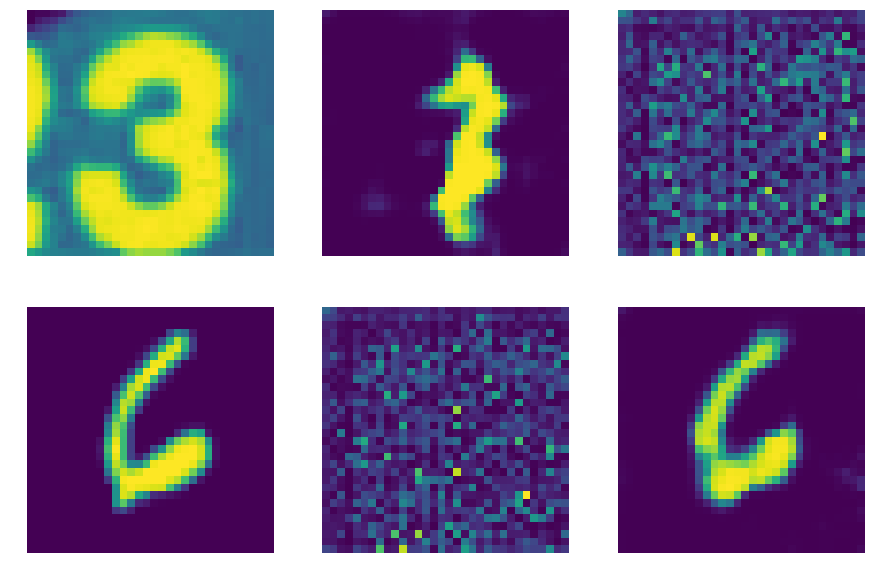

In [156]:
plt.rcParams['figure.figsize'] = (15, 10)
# plt.axes().set_aspect('equal', 'datalim')
#plt.axis([-3,3,-3,3])

index = 3
plt.subplot(2,3,1)
plt.imshow(X_svhn[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(X_source_trans[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(X_source_cyc[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(unnormalize(X_target[index].reshape(32,32)))
plt.axis('off')

plt.subplot(2,3,5)
#plt.imshow(np.transpose(X_target_trans[index].reshape(3,32,32), (1,2,0)))
plt.imshow(X_target_trans[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,6)
#plt.imshow(np.transpose(X_target_trans[index].reshape(3,32,32), (1,2,0)))
plt.imshow(X_target_cyc[index].reshape(32,32))
plt.axis('off')

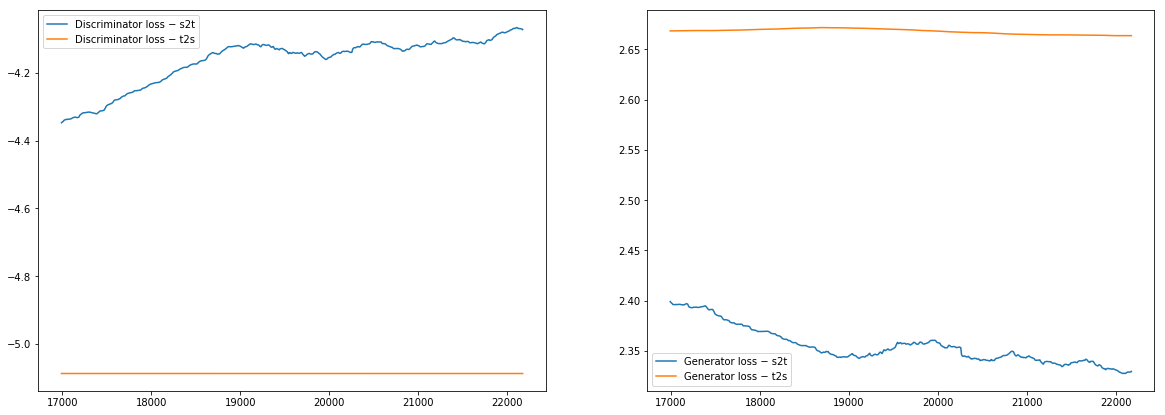

In [146]:
k = 2000
start = 15000
def smooth(x_list):
    return np.array([1/(2*k) * np.sum([x_list[i+j] for j in range(-k, k)]) for i in range(k, len(x_list)-k)])

plt.rcParams['figure.figsize'] = (20, 7)

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(D_s2t_loss_list[start:]), label="Discriminator loss − s2t")
plt.plot(iter_list[k+start:-k], smooth(D_t2s_loss_list[start:]), label="Discriminator loss − t2s")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(G_s2t_loss_list[start:]), label="Generator loss − s2t")
plt.plot(iter_list[k+start:-k], smooth(G_t2s_loss_list[start:]), label="Generator loss − t2s")
plt.legend()

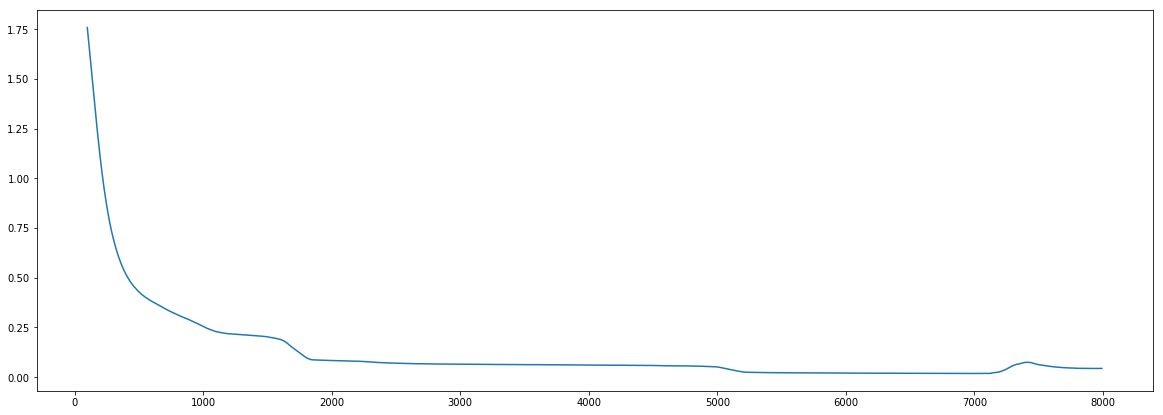

In [112]:
plt.plot(iter_list[k:-k], smooth(cyc_loss_list), label="Cycle loss")

## Debug

In [ ]:
#X_target_trans[10][:,:,:]

### Gradients

In [ ]:
ind = 0
print("Gradient with respect to", D_s2t_vars[ind])
gradient = sess.run(tf.gradients(D_s2t_loss, D_s2t_vars[ind]), feed_dict={ipt_source: sample_source, 
                                                                          ipt_target: sample_target, 
                                                                          latent_space: noise})
print("Min:", np.array(np.abs(gradient)).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
ind = 1
print("Gradient with respect to", G_s2t_vars[ind])
gradient = sess.run(tf.gradients(G_s2t_loss, G_s2t_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
ind = 10
print("Gradient with respect to", D_t2s_vars[ind])
gradient = sess.run(tf.gradients(D_t2s_loss, D_t2s_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
ind = 10
print("Gradient with respect to", G_t2s_vars[ind])
gradient = sess.run(tf.gradients(G_t2s_loss, G_t2s_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
D_s2t_vars[ind]

In [ ]:
D_s2t_vars

In [ ]:
X_test = sess.run([ipt_target_transf], feed_dict={ipt_source: sample_source, ipt_target: sample_target})[0][5]

In [ ]:
plt.imshow(X_test[:,:,0])

In [ ]:
gradient = sess.run(tf.gradients(gradient_penalty(ipt_source, "s2t"), ipt_source), feed_dict={ipt_source: sample_source})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())